In [1]:
import random
import gymnasium as gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import cv2
import imageio
'''
https://zhuanlan.zhihu.com/p/656515516
强化学习的两个主要组成部分就是：0、智能体或者大脑；1、环境。环境是给定的，也就是一般由openai提供的gym库，或者gymnasium这个库。这两个库提供了很多不同的强化学习环境，可以拿来调用的，上面的悬崖环境就在gymnasium库内的，gym库已经不再update了。
智能体或者大脑：智能体根据策略或者大脑，根据环境给出的奖励reward，以及分析环境提供的状态state信息，进而给出下一步的动作action；智能体还需要能够拿到状态信息，像robot就有许许多多的传感器，来感知环境的状态信息的。
环境：环境一般是连续的不离散的，环境需要根据智能体给出的动作action做出相应的改变，还需要给出相应的奖励reward，以及状态信息state，状态信息通常是需要智能体主动获取的，当然比较简单的环境可能就直接给出了状态信息，不需要智能体主动获取。
一般环境是gymnasium库提供的内容，环境会负责step(action)前进一步的，每次根据动作前进一步或者执行一步，会返回next_state, reward, done, _，也就分别是 下一个状体、奖励、是否结束的。或者重置环境reset()。
智能体是需要program的，也就是需要人工手动program，给出策略或者深度神经网络模拟大脑，每次从环境拿到状态信息state，以及reward奖励的，智能体根据奖励以及分析拿到的状态信息，做出决策的，也就是给出动作action。
'''

'\nhttps://zhuanlan.zhihu.com/p/656515516\n强化学习的两个主要组成部分就是：0、智能体或者大脑；1、环境。环境是给定的，也就是一般由openai提供的gym库，或者gymnasium这个库。这两个库提供了很多不同的强化学习环境，可以拿来调用的，上面的悬崖环境就在gymnasium库内的，gym库已经不再update了。\n智能体或者大脑：智能体根据策略或者大脑，根据环境给出的奖励reward，以及分析环境提供的状态state信息，进而给出下一步的动作action；智能体还需要能够拿到状态信息，像robot就有许许多多的传感器，来感知环境的状态信息的。\n环境：环境一般是连续的不离散的，环境需要根据智能体给出的动作action做出相应的改变，还需要给出相应的奖励reward，以及状态信息state，状态信息通常是需要智能体主动获取的，当然比较简单的环境可能就直接给出了状态信息，不需要智能体主动获取。\n一般环境是gymnasium库提供的内容，环境会负责step(action)前进一步的，每次根据动作前进一步或者执行一步，会返回next_state, reward, done, _，也就分别是 下一个状体、奖励、是否结束的。或者重置环境reset()。\n智能体是需要program的，也就是需要人工手动program，给出策略或者深度神经网络模拟大脑，每次从环境拿到状态信息state，以及reward奖励的，智能体根据奖励以及分析拿到的状态信息，做出决策的，也就是给出动作action。\n'

In [2]:
## 保存历史数据，采样历史数据，拿到历史数据
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity): ## 容量的大小
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))  ## 加入到队列内部

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)  ## 随机采样的呢，拿到采样的历史数据
        state, action, reward, next_state, done = zip(*transitions)  ## 使用zip来转置，也就是不同的自变量在不同的行
        return np.array(state), action, reward, np.array(next_state), done  ## 状态、动作、奖励、下一个状态，是否结束的

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)  ##  返回历史数据的总长度

In [3]:
## 构造智能体agent的大脑，也就是输入状态，返回该状态下，每个动作的动作价值
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim，
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  ## full connect层1
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim) ## full connect层2

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [4]:
##  构造智能体的
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim  ##  动作的dim
        ## 实例化智能体的大脑
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        # if np.random.random() < self.epsilon * np.exp(-self.count/100):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim) ## 随机选择一个动作
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device) ## 状态
            action = self.q_net(state).argmax().item()  ## 智能体的大脑，根据状态拿到动作价值，q_net返回值是每个动作的动作价值，然后拿到动作的
        return action

    ## 使用历史数据来训练智能体的大脑，两个大脑的，一个实时update做label，另一个延迟update做predict
    '''
    损失函数需要label和predict，但是强化学习是没有label的，所以需要人工构造label才行，DQN使用的构造方式是使用update步长不相同的两个Qnet，
    update数量较多的Qnet来做label，数量较少的Qnet来做predict。所以label就是使用的newest update的Qnet。相当是两个人，一个学的时间长些，
    一个学的时间短些，所以这个学习时间更长的人，可以当老师了，学习时间短的人，就只能当学生了。老师可以教导学生的。所以两个大脑模型Qnet，
    一个做老师，一个是学生，也就是一个label另一个则是predict。这样就构造出了相应的label。
    target_q_net使用下一个状态，然后Q-learning来predict当前(状态，动作)的动作价值，predict
    q_net使用当前状态和动作，直接算出当前(状态，动作)的动作价值，label
    '''
    def update(self, transition_dict):
        ## 初始化 状态、动作、奖励、下一个状态、是否结束的
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        ## target, 因该网络实时update，所以可以看作是真实值，也就是监督学习内的label，而目标网络延迟很多，目标网络的输出可以看作predict
        ## “真实”label，q_net输入当前的状态，返回值是当前状态下每个动作的动作价值，所以gather以后拿到的是：当前(状态和动作)对应的动作价值
        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值，延迟网络的输出
        ## 可以看作是predict，输入是下一个状态，返回值是下一个状态所有动作的动作价值内的最大值
        ## 用来算当前(状态和动作)下的动作价值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        ## Q-learning algorithm，算出的是当前(状态和动作)的动作价值
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        ## q_net的truth label 和 target_q_net的predict，算损失用来反向传播
        ## 也就是两个网络算出来的（状态和动作）对应的动作价值，用MSE来算损失函数的呢
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()   ##  反向传播求出梯度
        self.optimizer.step() ##  使用累加的梯度来update参数

        if self.count % self.target_update == 0:    ##  达到了给定的步长，复制最newest的参数给target_q_net网络，q_net是label，target_q_net是predict
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
allimage = []
for i in range(10):
    ## 训练的次数是
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0   ## 累积的奖励
            state = env.reset()  ## 环境随机重置的
            img = env.render()
            allimage.append(img)
            # cv2.imshow("CartPole-v1", img)
            # cv2.waitKey(-1)

            if len(state)!=2*2:
                state = state[0]
            done = False ## 是否结束的
            while not done:
                action = agent.take_action(state) ## 拿到动作价值最大的动作，取值可选值是：0 或者 1
                ## 环境根据动作，前进一步的，拿到下一个状态，奖励，是否终止，是否步长太长，info
                next_state, reward, terminated, truncated, info = env.step(action)  
                done = terminated | truncated  ## 终止或者步长太长，都会导致已经结束
                ## 将状态、动作、奖励、下一个状态、是否结束，加入到缓冲池，也就是历史内，用来训练大脑网络的
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state   ## 下一个状态赋值到当前状态
                episode_return += reward  ##累加奖励的
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:         ## 不停的和环境交互，直到缓冲池内的历史数据大于一定的数量，再开始训练网络的
                    ## 从缓冲池采样历史数据，用来训练大脑网络的
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {      ##  拿到的历史数据
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)  ## 训练大脑网络 q_net
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 764.86it/s, episode=50,
# return=9.300]
# Iteration 1: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s, episode=100,
# return=12.300]
# Iteration 2: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s, episode=150,
# return=123.000]
# Iteration 3: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it, episode=200,
# return=153.600]
# Iteration 4: 100%|██████████| 50/50 [01:30<00:00,  1.80s/it, episode=250,
# return=180.500]
# Iteration 5: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it, episode=300,
# return=185.000]
# Iteration 6: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, episode=350,
# return=193.900]
# Iteration 7: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it, episode=400,
# return=196.600]
# Iteration 8: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, episode=450,
# return=193.800]
# Iteration 9: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, episode=500,
# return=200.000]

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\10696\AppData\Local\Temp\ipykernel_2852\970432849.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float).to(self.device) ## 状态
Iteration 9: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, episode=500, return=425.100]


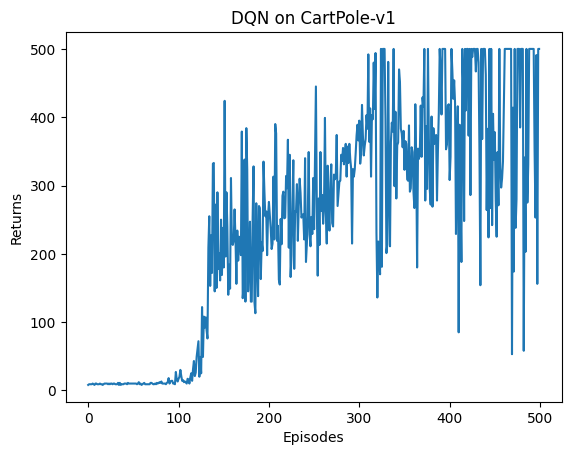

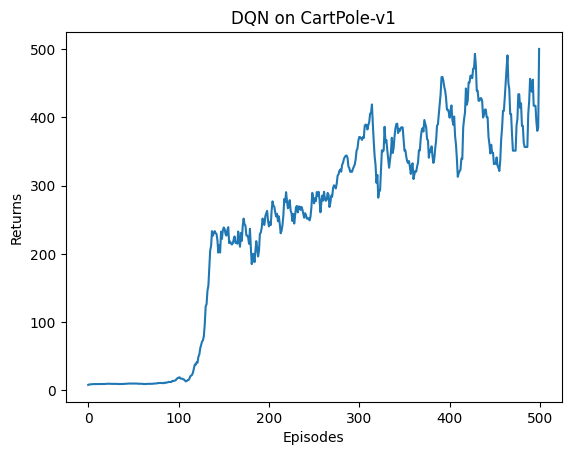

In [6]:
imageio.mimsave(r'C:\Users\10696\Desktop\access\Hands-on-RL\chapter7.gif', allimage, duration=10)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

<img src="./chapter7.gif" width="30%"/>

In [7]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)